In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import time
import importlib
import pandas as pd
import numpy as np
import pickle
import cnn_utils as cnn 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
importlib.reload(cnn)

C:\Users\zodes\AppData\Local\Temp\ipykernel_5812\1208615476.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<module 'cnn_utils' from 'c:\\Users\\zodes\\Documents\\Academics\\UChicago MPCS\\Machine Learning\\coding-ml-algos\\cnn\\cnn_utils.py'>

# CNN Implementation

The following code is from the [CNN tutorial at PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). It illustrates how the network is specified in PyTorch, and counts the number of parameters.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

def count_parameters(model):
    total_params = 0
    print(f"The number of trainable params in each layer:")
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print('  ', name, f'{params:,d}')
        total_params+=params
    print(f"Total trainable params: {total_params:,d}")
    return total_params
    
count_parameters(net)

The number of trainable params in each layer:
   conv1.weight 450
   conv1.bias 6
   conv2.weight 2,400
   conv2.bias 16
   fc1.weight 48,000
   fc1.bias 120
   fc2.weight 10,080
   fc2.bias 84
   fc3.weight 840
   fc3.bias 10
Total trainable params: 62,006


62006

### Test Conv, MaxPool, and Flatten

In [14]:
class FailTestError(Exception):
    pass

input_tensor = cnn.InputValue(np.arange(4*4*2).reshape((4,4,2)))
conv1 = cnn.InputValue(np.arange(3*3*2*4).reshape((3,3,2,4)))
bias1 = cnn.InputValue(np.arange(4))
v1 = cnn.InputValue(np.arange(16))

In [15]:
# Test Conv
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 0)
z = cnn.Add(y, bias1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x, y, conv1, bias1]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[17880., 18258., 18636., 19014.],
                    [20328., 20778., 21228., 21678.]],

                   [[27672., 28338., 29004., 29670.],
                    [30120., 30858., 31596., 32334.]]])
y_kernel_grad = np.array([[[[ 40.,  40.,  40.,  40.],
                             [ 48.,  48.,  48.,  48.]],

                            [[ 56.,  56.,  56.,  56.],
                             [ 64.,  64.,  64.,  64.]],

                            [[ 72.,  72.,  72.,  72.],
                             [ 80.,  80.,  80.,  80.]]],


                           [[[104., 104., 104., 104.],
                             [112., 112., 112., 112.]],

                            [[120., 120., 120., 120.],
                             [128., 128., 128., 128.]],

                            [[136., 136., 136., 136.],
                             [144., 144., 144., 144.]]],


                           [[[168., 168., 168., 168.],
                             [176., 176., 176., 176.]],

                            [[184., 184., 184., 184.],
                             [192., 192., 192., 192.]],

                            [[200., 200., 200., 200.],
                             [208., 208., 208., 208.]]]])
y_inputtensor_grad = np.array([[[  6.,  22.],
                                [ 44.,  76.],
                                [108., 140.],
                                [ 70.,  86.]],

                               [[108., 140.],
                                [280., 344.],
                                [408., 472.],
                                [236., 268.]],

                               [[300., 332.],
                                [664., 728.],
                                [792., 856.],
                                [428., 460.]],

                               [[198., 214.],
                                [428., 460.],
                                [492., 524.],
                                [262., 278.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Passed test on Conv with default settings")

Passed test on Conv with default settings


In [16]:
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x, y, conv1, bias1]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[ 5248.,  5336.,  5424.,  5512.],
                    [ 8608.,  8764.,  8920.,  9076.],
                    [10816., 11020., 11224., 11428.],
                    [ 7232.,  7384.,  7536.,  7688.]],

                   [[11856., 12084., 12312., 12540.],
                    [17880., 18258., 18636., 19014.],
                    [20328., 20778., 21228., 21678.],
                    [12912., 13236., 13560., 13884.]],

                   [[19152., 19572., 19992., 20412.],
                    [27672., 28338., 29004., 29670.],
                    [30120., 30858., 31596., 32334.],
                    [18672., 19188., 19704., 20220.]],

                   [[ 9792., 10136., 10480., 10824.],
                    [13312., 13852., 14392., 14932.],
                    [14368., 14956., 15544., 16132.],
                    [ 8192.,  8600.,  9008.,  9416.]]])
y_kernel_grad = np.array([[[[180., 180., 180., 180.],
                         [198., 198., 198., 198.]],

                        [[264., 264., 264., 264.],
                         [288., 288., 288., 288.]],

                        [[216., 216., 216., 216.],
                         [234., 234., 234., 234.]]],


                       [[[336., 336., 336., 336.],
                         [360., 360., 360., 360.]],

                        [[480., 480., 480., 480.],
                         [512., 512., 512., 512.]],

                        [[384., 384., 384., 384.],
                         [408., 408., 408., 408.]]],


                       [[[324., 324., 324., 324.],
                         [342., 342., 342., 342.]],

                        [[456., 456., 456., 456.],
                         [480., 480., 480., 480.]],

                        [[360., 360., 360., 360.],
                         [378., 378., 378., 378.]]]])
y_inputtensor_grad = np.array([[[ 280.,  344.],
                                [ 516.,  612.],
                                [ 516.,  612.],
                                [ 408.,  472.]],

                               [[ 708.,  804.],
                                [1206., 1350.],
                                [1206., 1350.],
                                [ 900.,  996.]],

                               [[ 708.,  804.],
                                [1206., 1350.],
                                [1206., 1350.],
                                [ 900.,  996.]],

                               [[ 664.,  728.],
                                [1092., 1188.],
                                [1092., 1188.],
                                [ 792.,  856.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Passed Test on Conv with non-zero padding")

Passed Test on Conv with non-zero padding


In [17]:
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 2, 1)
z = cnn.Add(y, bias1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x, y, conv1, bias1]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[ 5248.,  5336.,  5424.,  5512.],
                    [10816., 11020., 11224., 11428.]],

                   [[19152., 19572., 19992., 20412.],
                    [30120., 30858., 31596., 32334.]]])
y_kernel_grad = np.array([[[[ 20.,  20.,  20.,  20.],
                             [ 22.,  22.,  22.,  22.]],

                            [[ 40.,  40.,  40.,  40.],
                             [ 44.,  44.,  44.,  44.]],

                            [[ 48.,  48.,  48.,  48.],
                             [ 52.,  52.,  52.,  52.]]],


                           [[[ 40.,  40.,  40.,  40.],
                             [ 44.,  44.,  44.,  44.]],

                            [[ 80.,  80.,  80.,  80.],
                             [ 88.,  88.,  88.,  88.]],

                            [[ 96.,  96.,  96.,  96.],
                             [104., 104., 104., 104.]]],


                           [[[ 72.,  72.,  72.,  72.],
                             [ 76.,  76.,  76.,  76.]],

                            [[144., 144., 144., 144.],
                             [152., 152., 152., 152.]],

                            [[160., 160., 160., 160.],
                             [168., 168., 168., 168.]]]])
y_inputtensor_grad = np.array([[[134., 150.],
                                [268., 300.],
                                [134., 150.],
                                [166., 182.]],

                               [[268., 300.],
                                [536., 600.],
                                [268., 300.],
                                [332., 364.]],

                               [[134., 150.],
                                [268., 300.],
                                [134., 150.],
                                [166., 182.]],

                               [[230., 246.],
                                [460., 492.],
                                [230., 246.],
                                [262., 278.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Passed Test on Conv with stride 2 and padding 1")

Passed Test on Conv with stride 2 and padding 1


In [18]:
# Test MaxPool
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 2)
for component in [x,y,z,u,v]:
    component.forward()
v.grad = np.ones_like(v.value)
for component in [x,y,z,u, conv1, bias1]:
    component.grad = 0
for component in [v,u,z,y,x]:
    component.backward()

vvalue = np.array([[[17880., 18259., 18638., 19017.],
                    [20328., 20779., 21230., 21681.]],
                   [[27672., 28339., 29006., 29673.],
                    [30120., 30859., 31598., 32337.]]])
v_inputtensor_grad = np.array([[[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [1., 1., 1., 1.],
                                [1., 1., 1., 1.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [1., 1., 1., 1.],
                                [1., 1., 1., 1.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]]])

if not np.array_equal(v.value, vvalue):
    raise FailTestError("The output of MaxPool is incorrect")
if not np.array_equal(v.input_tensor.grad, v_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in MaxPool is incorrect")
print("Passed Test on MaxPool")

Passed Test on MaxPool


In [19]:
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 2, stride=4)
for component in [x,y,z,u,v]:
    component.forward()
v.grad = np.ones_like(v.value)
for component in [x,y,z,u, conv1, bias1]:
    component.grad = 0
for component in [v,u,z,y,x]:
    component.backward()

vvalue = np.array([[[17880., 18259., 18638., 19017.]]])
v_inputtensor_grad = np.array([[[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [1., 1., 1., 1.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],
                               
                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]]])

if not np.array_equal(v.value, vvalue):
    raise FailTestError("The output of MaxPool is incorrect")
if not np.array_equal(v.input_tensor.grad, v_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in MaxPool is incorrect")
print("Passed Test on MaxPool with non-default stride")

Passed Test on MaxPool with non-default stride


In [20]:
# Test Flatten
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 2)
w = cnn.Flatten(v)
o = cnn.Mul(w, v1)
for component in [x,y,z,u,v,w,o]:
    component.forward()
o.grad = np.ones_like(o.value)
for component in [x,y,z,u,v,w,conv1, bias1]:
    component.grad = 0
for component in [o,w,v,u,z,y,x]:
    component.backward()

wvalue = np.array([17880., 18259., 18638., 19017., 20328., 20779., 21230., 21681.,
       27672., 28339., 29006., 29673., 30120., 30859., 31598., 32337.])
w_inputtensor_grad = np.array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.]],

       [[ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]]])

if not np.array_equal(w.value, wvalue):
    raise FailTestError("The output of Flatten is incorrect")
if not np.array_equal(w.input_tensor.grad, w_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Flatten is incorrect")
print("Passed Test on Flatten")

Passed Test on Flatten


In [21]:
# Test ReLU
c1 = cnn.InputValue(np.sin(np.arange(3*3*4).reshape((3,3,4))).astype(np.float32))
b1 = cnn.InputValue(np.sin(np.arange(4)).astype(np.float32))
m1 = cnn.InputValue(np.cos(np.arange(3*3*4).reshape((3,3,4))).astype(np.float32))

x = cnn.Add(c1, b1)
y = cnn.RELU(x)
z = cnn.Mul(y, m1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x,y]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[0.        , 1.6829419 , 1.8185948 , 0.28224   ],
                    [0.        , 0.        , 0.6298819 , 0.7981066 ],
                    [0.98935825, 1.2535894 , 0.36527628, 0.        ]],

                   [[0.        , 1.2616379 , 1.8999047 , 0.7914079 ],
                    [0.        , 0.        , 0.15831017, 0.2909972 ],
                    [0.9129453 , 1.6781266 , 0.9004461 , 0.        ]],

                   [[0.        , 0.7091192 , 1.6718559 , 1.0974959 ],
                    [0.2709058 , 0.17783707, 0.        , 0.        ],
                    [0.5514267 , 1.8413827 , 1.4383801 , 0.        ]]], dtype=np.float32)
yagrad = np.array([[[ 0.        ,  0.5403023 , -0.41614684, -0.9899925 ],
                                [ 0.        ,  0.        ,  0.96017027,  0.75390226],
                                [-0.14550003, -0.91113025, -0.8390715 ,  0.        ]],

                               [[ 0.        ,  0.9074468 ,  0.13673721, -0.7596879 ],
                                [ 0.        ,  0.        ,  0.6603167 ,  0.9887046 ],
                                [ 0.40808207, -0.54772925, -0.99996084,  0.        ]],

                               [[ 0.        ,  0.99120283,  0.6469193 , -0.29213881],
                                [-0.9626059 , -0.74805754,  0.        ,  0.        ],
                                [ 0.8342234 , -0.01327675, -0.8485703 ,  0.        ]]],
                              dtype=np.float32)

if not np.array_equal(np.round(y.value.astype(np.float32),3), np.round(yvalue.astype(np.float32), 3)):
    raise FailTestError("The output of ReLU is incorrect")
if not np.array_equal(np.round(y.a.grad.astype(np.float32),3), np.round(yagrad.astype(np.float32), 3)):
    raise FailTestError("The gradient of input_tensor in ReLU is incorrect")
print("Passed Test on ReLU")

Passed Test on ReLU


# Applying to the CIFAR10 dataset
- Details: https://www.cs.toronto.edu/~kriz/cifar.html
- Label 0 to 9 refers to 0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck
- Only uses a subsample of 10000 images with 1000 of each class.


In [22]:
data = np.load('./cifar10_data/sub_data.npz')
X = np.float32(data['imgs'])/255.
# Reshape the valid image data to (idx, h, w, channel)
X = X.reshape(10000, 32, 32, 3)
y = np.float32(data['labels'])

# for simplicity, focus on the first four classes
# there are 4000 images in total
sub_idx = np.where(y<=3)[0]
X = X[sub_idx]
y = y[sub_idx]

# split in to train an test set
train_x, test_x = X[:3000], X[3000:]
train_y, test_y = y[:3000], y[3000:]

3.0


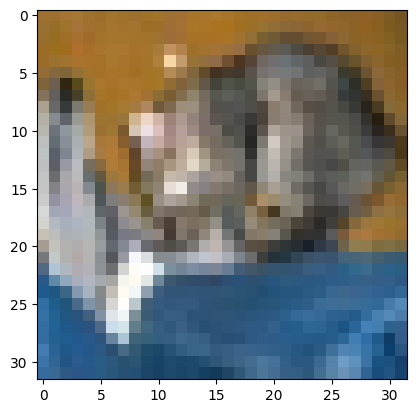

In [23]:
# below is what an image looks like
print(train_y[0])  # 3:cat
imgplot = plt.imshow(train_x[0])
plt.show()

### Debugging the fit function

Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <MaxPool> to the computational graph
Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <MaxPool> to the computational graph
Append <Flatten> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <SoftMax> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 1.2295, accy = 0.5000, [0.256 secs]


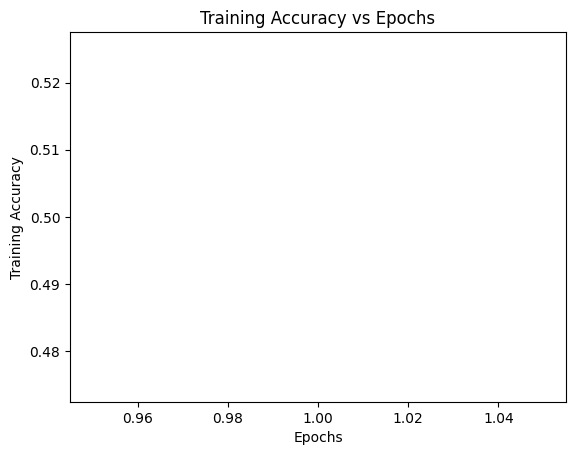

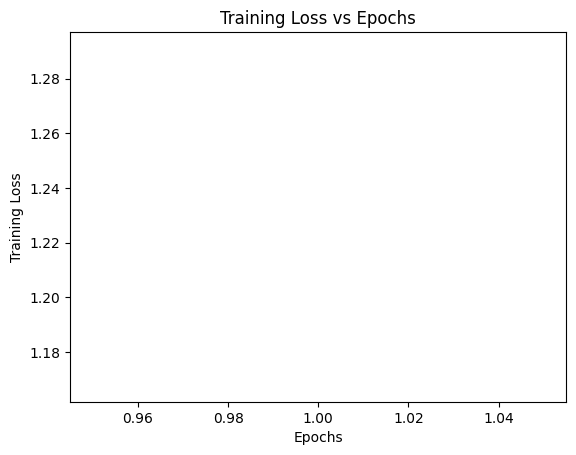

Congrats! Passed the test of your fit function, CNN model should be good to go!


In [24]:
model = cnn.CNN(num_labels=4)

# Use the provided sample weights for initialization to help debug
with open("./cifar10_data/sample_params.pkl", 'rb') as f:
    params = pickle.load(f)
model.set_params_by_dict(params)

# Use the first 2 samples to test if the gradients are correct
X = train_x[:2]
y = train_y[:2]

# When calling fit, a computational graph will be built first
model.fit_plot(X, y, alpha=0.01, t=1)

# Load the sample gradient for debugging
with open("./cifar10_data/sample_grad.pkl", 'rb') as f:
    sample_grad = pickle.load(f)

for k in params.keys():
    if not np.array_equal(np.round(sample_grad[k], 3), np.round(model.params[k].grad, 3)):
        raise FailTestError(f"gradient of param {k} is incorrect")
print("Congrats! Passed the test of your fit function, CNN model should be good to go!")


### Train CNN on the whole training dataset

Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <MaxPool> to the computational graph
Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <MaxPool> to the computational graph
Append <Flatten> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <SoftMax> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: train loss = 1.0815, accy = 0.5603, [336.902 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1: train loss = 0.8599, accy = 0.6447, [343.924 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2: train loss = 0.7823, accy = 0.6870, [339.679 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 3: train loss = 0.7542, accy = 0.6977, [338.217 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 4: train loss = 0.7337, accy = 0.6967, [338.128 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 5: train loss = 0.6169, accy = 0.7493, [335.056 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 6: train loss = 0.6406, accy = 0.7467, [334.429 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 7: train loss = 0.6234, accy = 0.7450, [376.810 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 8: train loss = 0.5748, accy = 0.7673, [336.894 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 9: train loss = 0.5334, accy = 0.7907, [333.813 secs]


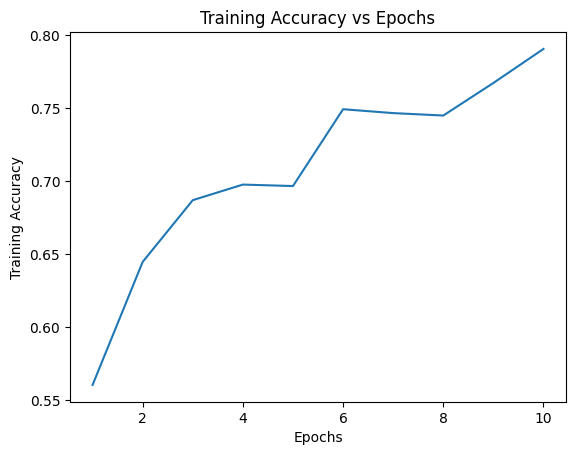

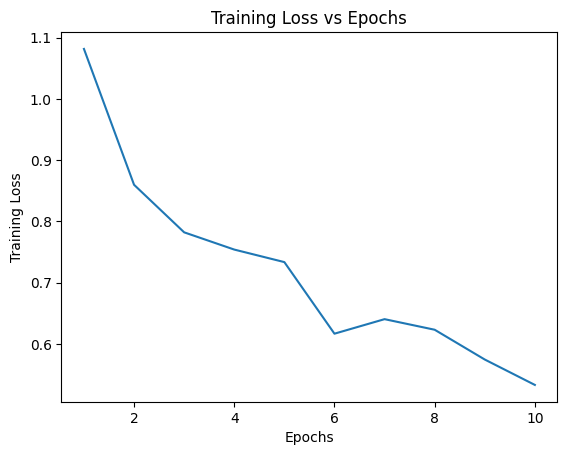

In [25]:
model = cnn.CNN(num_labels=4)
model.init_params_with_xavier()
model.fit_plot(train_x, train_y, 0.01, 10)

In [26]:
accy, loss = model.eval(test_x, test_y)
print("Test accuracy = %.4f, loss = %.4f" % (accy, loss))

Test accuracy = 0.6610, loss = 1.1266


The graphs show an upward trend in the training accuracy, indicating an improvement in the model performance
with a number of epochs. The training of the model across 10 epochs increase the accuracy from less than 55% to over 75% on the
training dataset, and 65% on the test dataset, indicating that the CNN is effective in the classification task it is
trained for.